![HELP-Logo](https://avatars1.githubusercontent.com/u/7880370?s=200&v=4)

# DMU 31 - Using Photometric Redshift Selection Functions


This notebook illustrates some example uses of the photometric selection functions produced in the [this selection function notebook](https://github.com/H-E-L-P/dmu_products/blob/master/dmu24/dmu24_ELAIS-N1/2_Photo-z_Selection_Function.ipynb). 

The goal is to create a selection function for the photometric redshifts that accounts for the varying redshift quality due to the inhomogeneous data coverage. The method outlined in the above notebook implicitly accounts for these effects due to the clustering of regions with similar optical depth properties.

Here we use the example field, ELAIS-N1 as an illustration.

### Set up imports

In [2]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
Unable to determine version.
This notebook was executed on: 
2018-06-20 18:01:10.773691


In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC
import healpy as hp
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy.stats import binom_conf_interval
from astropy.utils.console import ProgressBar
from astropy.modeling.fitting import LevMarLSQFitter

from sklearn.cluster import MiniBatchKMeans, MeanShift
from collections import Counter

from astropy.modeling import Fittable1DModel, Parameter

These functions are the logistic function (and its inverse) used to parametrise the fraction of sources that satisfy the criteria as a function of a given magnitude. 

(NB: To be folded into herschelhelp_python module for convenience.)

In [4]:
class GLF1D(Fittable1DModel):
    """
    Generalised Logistic Function 
    """
    inputs = ('x',)
    outputs = ('y',)

    A = Parameter()
    B = Parameter()
    K = Parameter()
    Q = Parameter()
    nu = Parameter()
    M = Parameter()
    
    @staticmethod
    def evaluate(x, A, B, K, Q, nu, M):
        top = K - A
        bottom = (1 + Q*np.exp(-B*(x-M)))**(1/nu)
        return A + (top/bottom)

    @staticmethod
    def fit_deriv(x, A, B, K, Q, nu, M):
        d_A = 1 - (1 + (Q*np.exp(-B*(x-M)))**(-1/nu))
        
        d_B = ((K - A) * (x-M) * (Q*np.exp(-B*(x-M)))) / (nu * ((1 + Q*np.exp(-B*(x-M)))**((1/nu) + 1)))

        d_K = 1 + (Q*np.exp(-B*(x-M)))**(-1/nu)
        
        d_Q = -((K - A) * (Q*np.exp(-B*(x-M)))) / (nu * ((1 + Q*np.exp(-B*(x-M)))**((1/nu) + 1)))
        
        d_nu = ((K-A) * np.log(1 + (Q*np.exp(-B*(x-M))))) / ((nu**2) * ((1 + Q*np.exp(-B*(x-M)))**((1/nu))))
        
        d_M = -((K - A) * (Q*B*np.exp(-B*(x-M)))) / (nu * ((1 + Q*np.exp(-B*(x-M)))**((1/nu) + 1)))

        return [d_A, d_B, d_K, d_Q, d_nu, d_M]
    
class InverseGLF1D(Fittable1DModel):
    """
    Generalised Logistic Function 
    """
    inputs = ('x',)
    outputs = ('y',)

    A = Parameter()
    B = Parameter()
    K = Parameter()
    Q = Parameter()
    nu = Parameter()
    M = Parameter()
    
    @staticmethod
    def evaluate(x, A, B, K, Q, nu, M):
        return M - (1/B)*(np.log((((K - A)/(x -A))**nu - 1)/Q))
    

## II - Set relevant initial parameters

In [5]:
FIELD = 'ELAIS-N1'
ORDER = 10

OUT_DIR = 'selection_functions'
SUFFIX = 'depths_20171016_photoz_20170725'

DEPTH_MAP = '../../dmu1/dmu1_ml_ELAIS-N1/data/depths_elais-n1_20171016.fits'
MASTERLIST = '../../dmu1/dmu1_ml_ELAIS-N1/data/master_catalogue_elais-n1_20170627.fits'

PZ_SEL_MAP = '../../dmu24/dmu24_ELAIS-N1/data/photo-z_selection_elais-n1_depths_20171016_photoz_20170725.fits'
PHOTOZS = '../../dmu24/dmu24_ml_ELAIS-N1/data/master_catalogue_elais-n1_20170706_photoz_20170725_irac1_optimised.fits'

## III - Load the depth maps

In [6]:
depth_map = Table.read(DEPTH_MAP)

# Get Healpix IDs
hp_idx = depth_map['hp_idx_O_{0}'.format(ORDER)]

# Calculate RA, Dec of depth map Healpix pixels for later plotting etc.
dm_hp_ra, dm_hp_dec = hp.pix2ang(2**ORDER, hp_idx, nest=True, lonlat=True)

pz_depth_map = Table.read('{0}/photo-z_selection_{1}_{2}.fits'.format(OUT_DIR, FIELD, SUFFIX).lower(), format='fits')

## IV - Using the photo-$z$ selection function

The selection function catalog contains a lot of information that can be exploited in a variety of ways depending on the science goal.
Here we use the selection function catalog to estimate the photometric redshift completeness across the field at a given magnitude for a desired band, e.g. `m_ap_cfht_megacam = 20`.

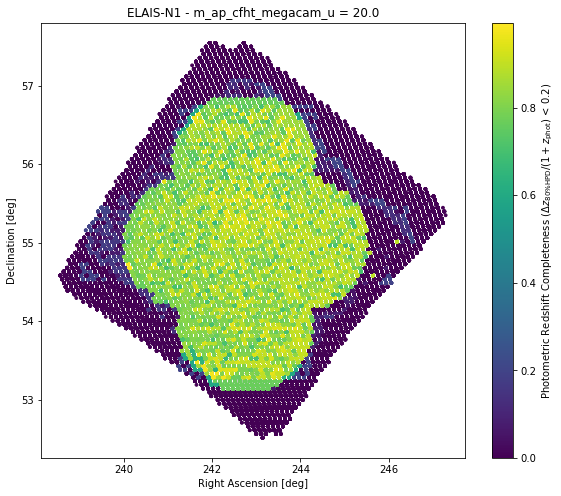

In [10]:
Fig, Ax = plt.subplots(1,1,figsize=(9.5,8))

photometry_band = 'm_ap_cfht_megacam_u'

mag = 20.
value = [GLF1D(*pars)(mag) for pars in pz_depth_map['pz_glf_{0}'.format(photometry_band)]]

Sc = Ax.scatter(dm_hp_ra, dm_hp_dec, c=value, cmap=plt.cm.viridis, s=8)

Ax.set_xlabel('Right Ascension [deg]')
Ax.set_ylabel('Declination [deg]')
Ax.set_title('{0} - {1} = {2}'.format(FIELD, photometry_band, mag))
CB = Fig.colorbar(Sc)
CB.set_label(r'Photometric Redshift Completeness ($\Delta z_{80\%\rm{HPD}} / (1 + z_{\rm{phot}}$) < 0.2)')

Fig.savefig('pz_completeness_map_{0}_{1}.png'.format(photometry_band, mag), format='png', dpi=150, bbox_inches='tight')

Now we do the same as above but for a different reference filter:

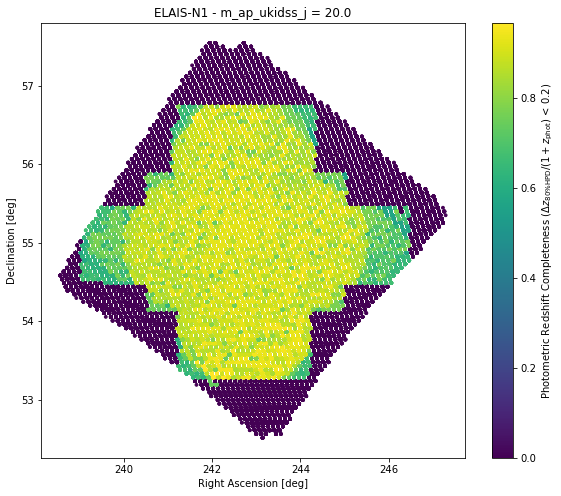

In [13]:
Fig, Ax = plt.subplots(1,1,figsize=(9.5,8))

photometry_band = 'm_ap_ukidss_j'

mag = 20.
value = [GLF1D(*pars)(mag) for pars in pz_depth_map['pz_glf_{0}'.format(photometry_band)]]

Sc = Ax.scatter(dm_hp_ra, dm_hp_dec, c=value, cmap=plt.cm.viridis, s=8)

Ax.set_xlabel('Right Ascension [deg]')
Ax.set_ylabel('Declination [deg]')
Ax.set_title('{0} - {1} = {2}'.format(FIELD, photometry_band, mag))
CB = Fig.colorbar(Sc)
CB.set_label(r'Photometric Redshift Completeness ($\Delta z_{80\%\rm{HPD}} / (1 + z_{\rm{phot}}$) < 0.2)')

An advantage of the GLF employed in this work is that it can be inverted and the same fitted parameters can be used to estimate depth in a given HEALpix corresponding to a desired photo-$z$ completeness. 
Plotting below is the magnitude at which the photo-$z$ completeness equals 80%. We can therefore use this information to: 
1. Select regions of the field which reach the desired completeness, and
2. Determine the required magnitude cut to reach the desired completeness for each HEALpix.

The second point could be used to for example select a sample which has homogeneous redshift quality.

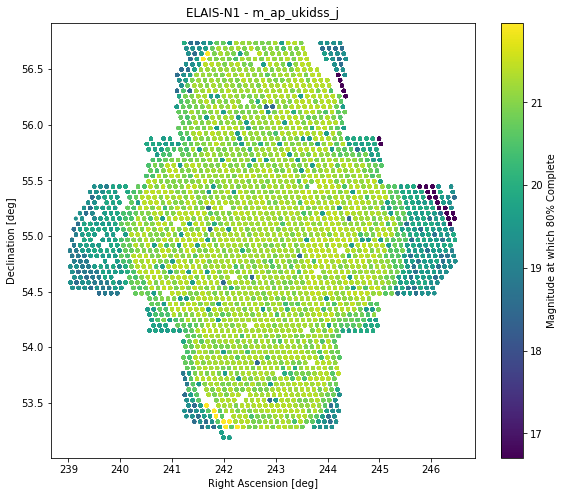

In [12]:
Fig, Ax = plt.subplots(1,1,figsize=(9.5,8))

photometry_band = 'm_ap_ukidss_j'

model = GLF1D(*pz_depth_map['pz_glf_{0}'.format(photometry_band)][0])

completeness = 0.8
mag_complete = [InverseGLF1D(*pars)(completeness) for pars in pz_depth_map['pz_glf_{0}'.format(photometry_band)]]

Sc = Ax.scatter(dm_hp_ra, dm_hp_dec, c=mag_complete, cmap=plt.cm.viridis, s=8)

Ax.set_xlabel('Right Ascension [deg]')
Ax.set_ylabel('Declination [deg]')
Ax.set_title('{0} - {1}'.format(FIELD, photometry_band))
CB = Fig.colorbar(Sc)
CB.set_label(r'Magnitude at which {0:.0f}% Complete'.format(completeness*100))

In other notebooks we will illustrate these use-cases in  aspecific scientific context such as accounting for the selection effects in defined science sample.

 ![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)
 
**Author**: [Kenneth Duncan](http://dunkenj.github.io)

The Herschel Extragalactic Legacy Project, ([HELP](http://herschel.sussex.ac.uk/)), is a [European Commission Research Executive Agency](https://ec.europa.eu/info/departments/research-executive-agency_en)
funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement
Number 607254.

[Acknowledgements](http://herschel.sussex.ac.uk/acknowledgements)
